In [6]:
import requests
import numpy as np
import pandas as pd
import datetime 
import matplotlib.pyplot as plt

# Get Prices from CFH Price Server

In [7]:
url_base = 'https://api.olivineinc.com/i/lbnl/v1/prices/cfh/'
endpoint_dict = {'SummerHDP': url_base + 'SummerHDP',
                'SummerLD-TOU': url_base + 'SummerLD-TOU',
                'SummerMildHDP':url_base + 'SummerMildHDP',
                 'SummerHDPg':url_base + 'SummerHDPg',
                 'FallHDP':url_base + 'FallHDP',
                 'FallHDPg':url_base + 'FallHDPg',
                 'WinterHDP':url_base + 'WinterHDP',
                 'WinterHDPg':url_base + 'WinterHDPg',
                 'SpringHDP':url_base + 'SpringHDP',
                 'SpringHDPg':url_base + 'SpringHDPg',
                }

In [8]:
def get_rate(url):
    r = requests.get(url)
    price_dict = r.json()
    interval_prices = price_dict.get('prices')
    start_str = price_dict.get('timeOfFirstPriceLocal')
    start_ts = pd.Timestamp(start_str)
    interval_prices.insert(0, {'duration':'00:00:00'})
    df = pd.DataFrame(interval_prices)
    df.duration = pd.to_timedelta(df.duration)
    df['end_time'] = start_ts + df.duration.cumsum()
    hourly_df = df.set_index('end_time').resample('60T').bfill().reset_index()
    hourly_df['start_time'] = hourly_df['end_time'] - hourly_df['end_time'].diff()
    hourly_df = hourly_df.drop(index = 0)
    return hourly_df.set_index('start_time')

In [9]:
def plot_rate(df, rate_name, show = True):
    fig = plt.figure(figsize = (11,5))
    idx = [x.strftime('%H') for x in df.index]
    plt.step(idx, df.price, where = 'post', label = rate_name)
    plt.ylabel('$/kWh')
    plt.xlabel('Hour of Day')
    plt.grid(alpha = 0.4)
    plt.xticks(idx)
    #plt.title('TOU HDP Price Signals')
    plt.legend()
    plt.ylim(0,0.9)
    if show:
        plt.show()

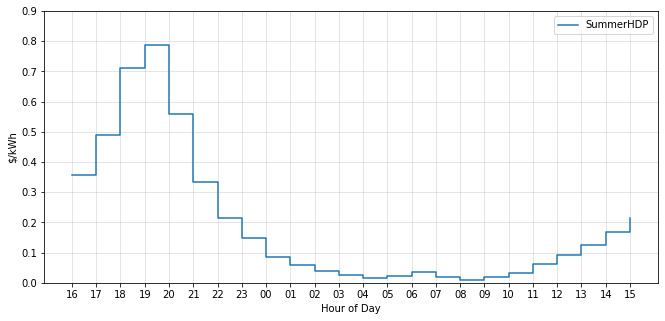

In [13]:
rate_name = 'SummerHDP'
summer_hdp_df = get_rate(endpoint_dict[rate_name])
plot_rate(summer_hdp_df, rate_name)


# Plotting GHG price stacked with HDP

In [13]:
def get_price_ghg_df(price_url, ghg_adder = 0.2):
    """
    ghg_adder: float
    A simple method of co-optimizing for GHG emissions and price signals is to attribute a burden value to the GHG marginal emissions. 
    This $/tonCO2 burden value describes how valuable it is to avoid GHG emissions
    multiplying the GHG emissions rate by an appropriate $/ton burden value creates a $/kWh signal that can be combined with a price signal.
    The default value is $0.2/kgCO2 ($200/tonne CO2 ) 
    """
    price = get_rate(price_url)
    ghg = get_rate(price_url + 'g').rename(columns={'price':'ghg'})
    combined_df = price.join(ghg, rsuffix= '_g')
    ghg_burden = ghg_adder * combined_df['ghg']
    stacked = combined_df['price'] + ghg_burden
    combined_df['stacked'] = stacked
    combined_df['ghg_burden'] = ghg_burden
    return combined_df



In [14]:
def plot_stacked(df):
    fig, ax1 = plt.subplots(figsize = (11,5))
    plt.rcParams["figure.figsize"] = (11,5)
    idx = df.index.strftime('%H')
    ax1.step(idx, df['stacked'], where = 'post')
    ax1.step(idx, df['ghg_burden'], where = 'post')
    ax1.fill_between(idx, df['ghg_burden'], df['stacked'], step = 'post', alpha = 0.3, color = 'tab:blue', label = 'Price ($/kWh)')
    ax1.fill_between(idx, np.linspace(0,0,24), df['ghg_burden'], step = 'post', alpha = 0.3, color = 'tab:orange', label = 'GHG Burden ($/kWh)')
    ax1.set_ylabel('Price $/kWh')
    ax1.set_xlabel('Hour of Day')
    ax1.grid(alpha = 0.4)
    ax1.set_xticks(idx)
    ax1.legend()


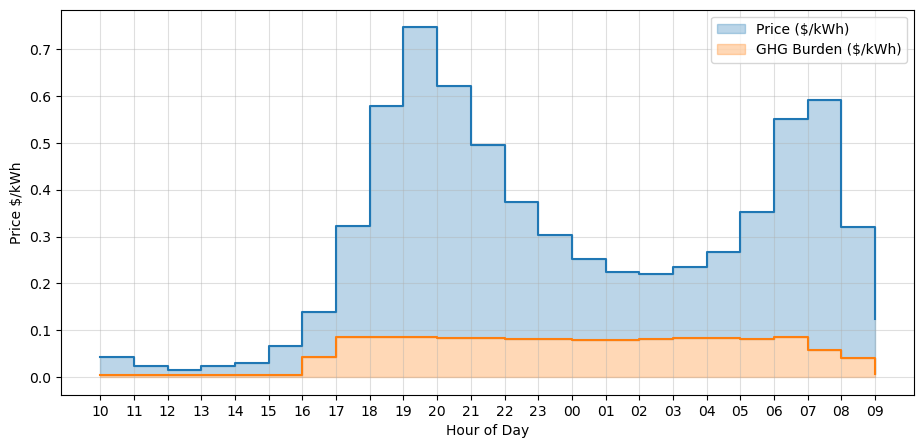

In [15]:
df = get_price_ghg_df(endpoint_dict['SpringHDP'], ghg_adder = 0.2)
plot_stacked(df)

In [16]:
def reorder_df_by_hour(df):
    df_sorted = df.copy()
    df_sorted['time'] = df_sorted.index.time
    return df_sorted.sort_values(by = 'time')

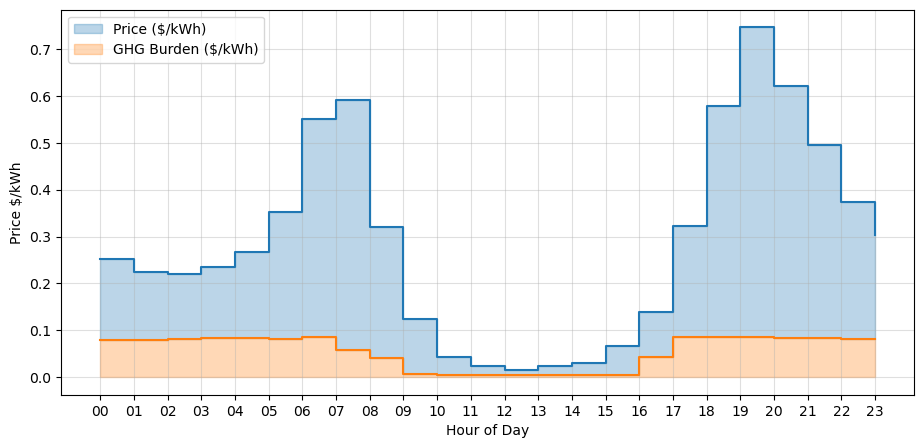

In [17]:
df_sorted = reorder_df_by_hour(df)
plot_stacked(df_sorted)

# Code Walkthrough/description

r = requests.get(url)
price_dict = r.json()
interval_prices = price_dict.get('prices')For the summer hourly highly dynamic price signal you can use:
https://api.olivineinc.com/i/lbnl/v1/prices/cfh/SummerHDP

For the summer TOU signal you can use:
https://api.olivineinc.com/i/lbnl/v1/prices/cfh/SummerLD-TOU

If you would like to use the additional signals of SummerMildHDP or TwoPeakHDP (signal with two price peaks):
https://api.olivineinc.com/i/lbnl/v1/prices/cfh/SummerMildHDP
https://api.olivineinc.com/i/lbnl/v1/prices/cfh/TwoPeakHDP

Price signals are first turned into a dataframe with durations, then with times

In [14]:
#olivine server
url = 'https://api.olivineinc.com/i/lbnl/v1/prices/cfh/SummerHDP'

r = requests.get(url)
price_dict = r.json()
interval_prices = price_dict.get('prices')
#adding first duration so bfill works later
interval_prices.insert(0, {'duration':'00:00:00'})
#creating dataframe with duration and indices
df = pd.DataFrame(interval_prices)
df.duration = pd.to_timedelta(df.duration)
display(df)

,duration,index,price
0,0 days 00:00:00,NaN,NaN
1,0 days 01:00:00,0.0,0.0192
2,0 days 01:00:00,1.0,0.0309
3,0 days 01:00:00,2.0,0.0612
4,0 days 01:00:00,3.0,0.0925
5,0 days 01:00:00,4.0,0.1244
6,0 days 01:00:00,5.0,0.1667
7,0 days 01:00:00,6.0,0.2148
8,0 days 01:00:00,7.0,0.3563
9,0 days 01:00:00,8.0,0.4893


In [15]:
#getting start time
start_str = price_dict.get('timeOfFirstPriceLocal')
start_ts = pd.Timestamp(start_str)
print(start_str)

2023-04-05T09:00:00-07:00


In [16]:
#Finding the datetime end of each period
df['end_time'] = start_ts + df.duration.cumsum()
#Upsampling using the end time
hourly_df = df.set_index('end_time').resample('60T').bfill().reset_index()
#adding a start time for each period
hourly_df['start_time'] = hourly_df['end_time'] - hourly_df['end_time'].diff()
#dropping 0 duration first price
hourly_df = hourly_df.drop(index = 0)
#Showing dataframe with start time and end times of signal
display(hourly_df[['start_time', 'end_time','price']])

,start_time,end_time,price
1,2023-04-05 09:00:00-07:00,2023-04-05 10:00:00-07:00,0.0192
2,2023-04-05 10:00:00-07:00,2023-04-05 11:00:00-07:00,0.0309
3,2023-04-05 11:00:00-07:00,2023-04-05 12:00:00-07:00,0.0612
4,2023-04-05 12:00:00-07:00,2023-04-05 13:00:00-07:00,0.0925
5,2023-04-05 13:00:00-07:00,2023-04-05 14:00:00-07:00,0.1244
6,2023-04-05 14:00:00-07:00,2023-04-05 15:00:00-07:00,0.1667
7,2023-04-05 15:00:00-07:00,2023-04-05 16:00:00-07:00,0.2148
8,2023-04-05 16:00:00-07:00,2023-04-05 17:00:00-07:00,0.3563
9,2023-04-05 17:00:00-07:00,2023-04-05 18:00:00-07:00,0.4893
10,2023-04-05 18:00:00-07:00,2023-04-05 19:00:00-07:00,0.7098
